In [2]:
import math
import numpy as np
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
import ikpy
import ikpy.chain
import ikpy.utils.plot as plot
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D
import cv2
import heapq

In [3]:
active_links =  [False, False, False, False,  True, True, True, True, True, True, True, False, False, False]
arm_joints =  [0, 0, 0.35, 0,  0.07, 1.02, -3.16, 1.27, 1.32, 0.0, 1.41, 0, 0, 0.045]
my_chain = ikpy.chain.Chain.from_urdf_file("arm.urdf", active_links_mask=active_links)

In [13]:
def ik_arm(target_position, target_orientation=None, initial = None):
    target_frame = np.eye(4)
    target_frame[:3, 3] = target_position
    global arm_joints
    if initial is None:
        initial = arm_joints
    # else:
        # target_frame[:3, :3] = [[0,1,0],[1,0,0],[0,0,1]]
    if target_orientation is not None:
        target_frame[:3, :3] = target_orientation
        print("orientation given")
        return my_chain.inverse_kinematics_frame(target_frame, initial_position=initial, orientation_mode="all")
    else:
        return my_chain.inverse_kinematics_frame(target_frame, initial_position=initial)

In [14]:
pose_arm = ik_arm([0.6, 0.1, 1.2], target_orientation = [[1,0,0],
                                                        [0,1,0],
                                                        [0,0,1]])
print(my_chain.forward_kinematics(pose_arm))

orientation given
[[ 0.99984196 -0.01529394 -0.00906395  0.70314714]
 [ 0.01519327  0.99982326 -0.01107345  0.05654532]
 [ 0.00923171  0.01093398  0.99989761  1.10346596]
 [ 0.          0.          0.          1.        ]]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

###############################################################################
## Base Code
###############################################################################
class Node:
    """
    Node for RRT Algorithm. This is what you'll make your graph with!
    """
    def __init__(self, pt, parent=None):
        self.point = pt # n-Dimensional point
        self.parent = parent # Parent node
        self.path_from_parent = [] # List of points along the way from the parent node (for edge's collision checking)
    def getCost(self):
        node = self
        cost = 0
        while node.parent is not None:
            cost += math.dist(node.point, node.parent.point)
            node = node.parent
        return cost

In [5]:
def get_nd_obstacle(state_bounds):
    '''
    Function to return a circular obstacle in an n-dimensional world
    :param state_bounds: Array of min/max for each dimension
    :return: A single circular obstacle in form of a list with 1st entry as the circle center and the 2nd as the radius
    '''
    center_vector = []
    for d in range(state_bounds.shape[0]):
        center_vector.append(state_bounds[d][0] + random.random()*(state_bounds[d][1]-state_bounds[d][0]))
    radius = random.random() * 0.6 # Downscaling the radius
    return [np.array(center_vector), radius]

def setup_random_2d_world():
    '''
    Function that sets a 2D world with fixed bounds and # of obstacles
    :return: The bounds, the obstacles, the state_is_valid() function
    '''
    state_bounds = np.array([[0,10],[0,10]]) # matrix of min/max values for each dimension
    obstacles = [] # [pt, radius] circular obstacles
    for n in range(30):
        obstacles.append(get_nd_obstacle(state_bounds))

    def state_is_valid(state):
        '''
        Function that takes an n-dimensional point and checks if it is within the bounds and not inside the obstacle
        :param state: n-Dimensional point
        :return: Boolean whose value depends on whether the state/point is valid or not
        '''
        for dim in range(state_bounds.shape[0]):
            if state[dim] < state_bounds[dim][0]: return False
            if state[dim] >= state_bounds[dim][1]: return False
        for obs in obstacles:
            if np.linalg.norm(state - obs[0]) <= obs[1]: return False
        return True

    return state_bounds, obstacles, state_is_valid

def setup_fixed_test_2d_world():
    '''
    Function that sets a test 2D world with fixed bounds and # of obstacles
    :return: The bounds, the obstacles, the state_is_valid() function
    '''
    state_bounds = np.array([[0,1],[0,1]]) # matrix of min/max values for each dimension
    obstacles = [] # [pt, radius] circular obstacles
    obstacles.append([[0.5,0.5],0.2])
    obstacles.append([[0.1,0.7],0.1])
    obstacles.append([[0.7,0.2],0.1])

    # Pretty wild but you can have nested functions in python and in this case it will retain
    # its local variables state_bounds and obstacles. You won't need to pass them later.
    def state_is_valid(state):
        '''
        Function that takes an n-dimensional point and checks if it is within the bounds and not inside the obstacle
        :param state: n-Dimensional point
        :return: Boolean whose value depends on whether the state/point is valid or not
        '''
        for dim in range(state_bounds.shape[0]):
            if state[dim] < state_bounds[dim][0]: return False
            if state[dim] >= state_bounds[dim][1]: return False
        for obs in obstacles:
            if np.linalg.norm(state - obs[0]) <= obs[1]: return False
        return True

    return state_bounds, obstacles, state_is_valid

def _plot_circle(x, y, radius, color="-k"):
    '''
    Internal function to plot a 2D circle on the current pyplot object
    :param x: The x coordinate of the circle
    :param y: The y coordinate of the circle
    :param radius: The radius of the circle
    :param color: Matplotlib color code
    :return: None
    '''
    deg = np.linspace(0,360,50)

    xl = [x + radius * math.cos(np.deg2rad(d)) for d in deg]
    yl = [y + radius * math.sin(np.deg2rad(d)) for d in deg]
    plt.plot(xl, yl, color)

def visualize_2D_graph(state_bounds, obstacles, nodes, goal_point=None, filename=None):
    '''
    Function to visualise the 2D world, the RRT graph, path to goal if goal exists
    :param state_bounds: Array of min/max for each dimension
    :param obstacles: Locations and radii of spheroid obstacles
    :param nodes: List of vertex locations
    :param goal_point: Point within state_bounds to target with the RRT. (OPTIONAL, can be None)
    :param filename: Complete path to the file on which this plot will be saved
    :return: None
    '''
    fig = plt.figure()
    plt.xlim(state_bounds[0,0], state_bounds[0,1])
    plt.ylim(state_bounds[1,0], state_bounds[1,1])

    for obs in obstacles:
        _plot_circle(obs[0][0], obs[0][1], obs[1])

    goal_node = None
    for node in nodes:
        if node.parent is not None:
            node_path = np.array(node.path_from_parent)
            plt.plot(node_path[:,0], node_path[:,1], '-b')
        # The goal may not be on the RRT so we are finding the point that is a 'proxy' for the goal
        if goal_point is not None and np.linalg.norm(node.point - np.array(goal_point)) <= 1e-5:
            goal_node = node
            plt.plot(node.point[0], node.point[1], 'k^')
        else:
            plt.plot(node.point[0], node.point[1], 'ro')

    plt.plot(nodes[0].point[0], nodes[0].point[1], 'ko')

    if goal_node is not None:
        cur_node = goal_node
        while cur_node is not None: 
            if cur_node.parent is not None:
                node_path = np.array(cur_node.path_from_parent)
                plt.plot(node_path[:,0], node_path[:,1], '-y')
                cur_node = cur_node.parent
            else:
                break

    if goal_point is not None:
        plt.plot(goal_point[0], goal_point[1], 'gx')

    if filename is not None:
        fig.savefig(filename)
    else:
        plt.show()

def get_random_valid_vertex(state_is_valid, bounds):
    '''
    Function that samples a random n-dimensional point which is valid (i.e. collision free and within the bounds)
    :param state_valid: The state validity function that returns a boolean
    :param bounds: The world bounds to sample points from
    :return: n-Dimensional point/state
    '''
    vertex = None
    while vertex is None: # Get starting vertex
        pt = np.random.rand(bounds.shape[0]) * (bounds[:,1]-bounds[:,0]) + bounds[:,0]
        if state_is_valid(pt):
            vertex = pt
    return vertex

###############################################################################
## END BASE CODE
###############################################################################

def get_nearest_vertex(node_list, q_point):
    '''
    Function that finds a node in node_list with closest node.point to query q_point
    :param node_list: List of Node objects
    :param q_point: n-dimensional array representing a point
    :return Node in node_list with closest node.point to query q_point
    '''

    # TODO: Your Code Here
    closestDistance = math.dist(q_point, node_list[0].point)
    closestNode = node_list[0]
    for i in node_list:
        distance = math.dist(q_point, i.point)
        if distance < closestDistance:
            closestNode = i
            closestDistance = distance
    return closestNode

def steer(from_point, to_point, delta_q):
    '''
    :param from_point: n-Dimensional array (point) where the path to "to_point" is originating from (e.g., [1.,2.])
    :param to_point: n-Dimensional array (point) indicating destination (e.g., [0., 0.])
    :param delta_q: Max path-length to cover, possibly resulting in changes to "to_point" (e.g., 0.2)
    :return path: Array of points leading from "from_point" to "to_point" (inclusive of endpoints)  (e.g., [ [1.,2.], [1., 1.], [0., 0.] ])
    '''
    # TODO: Figure out if you can use "to_point" as-is, or if you need to move it so that it's only delta_q distance away
    dist = math.dist(from_point, to_point)
    if delta_q < dist:
        to_point = from_point + (delta_q/dist) *(to_point - from_point)
        
    # TODO Use 
    # the np.linspace function to get 10 points along the path from "from_point" to "to_point"
    path = np.linspace(from_point, to_point, num = 10)
    return path

def check_path_valid(path, state_is_valid):
    '''
    Function that checks if a path (or edge that is made up of waypoints) is collision free or not
    :param path: A 1D array containing a few (10 in our case) n-dimensional points along an edge
    :param state_is_valid: Function that takes an n-dimensional point and checks if it is valid
    :return: Boolean based on whether the path is collision free or not
    '''
    for i in path: 
        if not state_is_valid(i):
            return False
    return True
    # TODO: Your Code Here
    raise NotImplementedError

In [22]:
def rrt(state_bounds, state_is_valid, starting_point, goal_point, k, delta_q, r=None):
    '''
    TODO: Implement the RRT algorithm here, making use of the provided state_is_valid function.
    RRT algorithm.
    If goal_point is set, your implementation should return once a path to the goal has been found 
    (e.g., if q_new.point is within 1e-5 distance of goal_point), using k as an upper-bound for iterations. 
    If goal_point is None, it should build a graph without a goal and terminate after k iterations.

    :param state_bounds: matrix of min/max values for each dimension (e.g., [[0,1],[0,1]] for a 2D 1m by 1m square)
    :param state_is_valid: function that maps states (N-dimensional Real vectors) to a Boolean (indicating free vs. forbidden space)
    :param starting_point: Point within state_bounds to grow the RRT from
    :param goal_point: Point within state_bounds to target with the RRT. (OPTIONAL, can be None)
    :param k: Number of points to sample
    :param delta_q: Maximum distance allowed between vertices
    :param r: distance of nodes to check for cost in RRT*
    :returns List of RRT graph nodes
    '''
    node_list = []
    node_list.append(Node(starting_point, parent=None)) # Add Node at starting point with no parent
    if r is None or r > delta_q:
        r=delta_q
    for i in range(k):
        goalChecked = False
        point=[]
        if goal_point is not None and random.random() < 0.05 :
            point = goal_point
        else:
            goalChecked=True
        while True:
            if goalChecked:
                point = get_random_valid_vertex(state_is_valid, state_bounds)
            else:
                goalChecked=True
            closest = get_nearest_vertex(node_list, point)
            path = steer(closest.point, point, delta_q)
            point = path[-1]
            # 10 nodes in path
            if check_path_valid(path, state_is_valid):
                # replace node with lower cost node in radius r if it exists
                cost = closest.getCost()+math.dist(closest.point, point)
                for n in node_list:
                    if math.dist(n.point, point) < r:
                        newCost = n.getCost() + math.dist(n.point, point)
                        if newCost < cost:
                            newPath = steer(n.point, point, delta_q)
                            if check_path_valid(newPath, state_is_valid):
                                cost = newCost
                                path = newPath
                                closest = n
                # check nearby nodes if rewiring will produce lower cost
                node = Node(point, parent=closest)
                node.path_from_parent = path
                cost = node.getCost()
                for n in node_list:
                    if math.dist(n.point, point) < r:
                        newCost = cost + math.dist(n.point, point)
                        if newCost < n.getCost():
                            newPath = steer(n.point, point, delta_q)
                            if check_path_valid(newPath, state_is_valid):
                                n.parent = node
                                n.path_from_parent = newPath
                node_list.append(node)
                # check if goal is within reach
                # if goal_point is not None and math.dist(goal_point, path[-1]) < delta_q:
                #     path = steer(path[-1], goal_point, delta_q)
                #     if check_path_valid(path, state_is_valid):
                #         node = Node(goal_point, parent = node)
                #         node.path_from_parent = path
                #         node_list.append(node)
                #         return node_list
                if goal_point is not None and math.dist(goal_point, point) == 0:
                    return node_list
                break
    # if goal_point == None:
    #     return node_list
    # else:
    #     return None
    
    
    # TODO: Your code here
    # TODO: Make sure to add every node you create onto node_list, and to set node.parent and node.path_from_parent for each

    return node_list

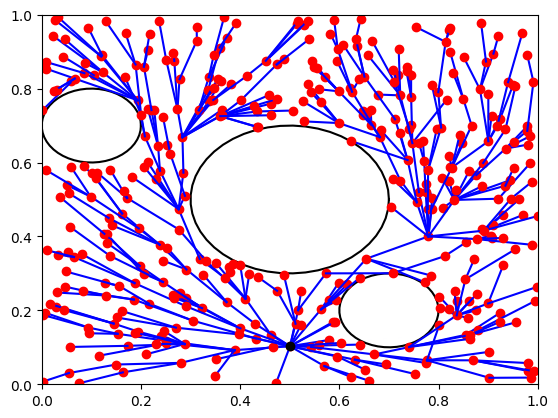

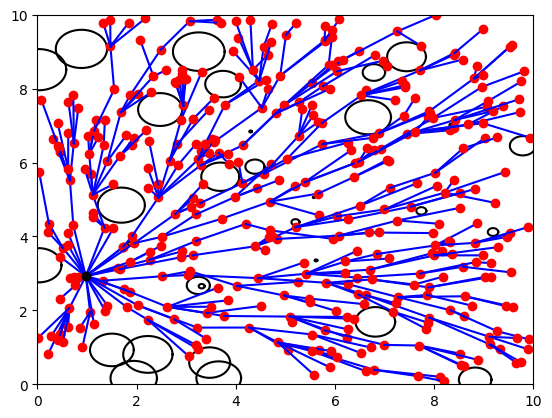

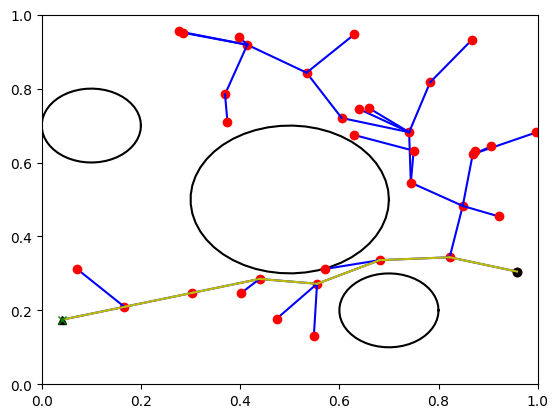

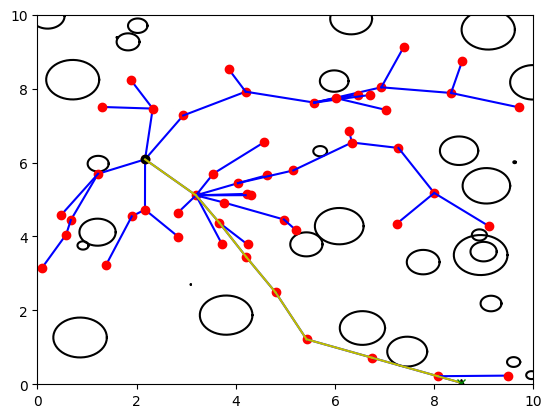

In [23]:
K = 400 # Feel free to adjust as desired
bounds, obstacles, validity_check = setup_fixed_test_2d_world()
starting_point = get_random_valid_vertex(validity_check, bounds)
nodes = rrt(bounds, validity_check, starting_point, None, K, np.linalg.norm(bounds/10.))
visualize_2D_graph(bounds, obstacles, nodes, None, 'rrt_run1.png')

bounds, obstacles, validity_check = setup_random_2d_world()
starting_point = get_random_valid_vertex(validity_check, bounds)
nodes = rrt(bounds, validity_check, starting_point, None, K, np.linalg.norm(bounds/10.))
visualize_2D_graph(bounds, obstacles, nodes, None, 'rrt_run2.png')

bounds, obstacles, validity_check = setup_fixed_test_2d_world()
starting_point = get_random_valid_vertex(validity_check, bounds)
goal_point = get_random_valid_vertex(validity_check, bounds)
while np.linalg.norm(starting_point - goal_point) < np.linalg.norm(bounds/2.):
    starting_point = get_random_valid_vertex(validity_check, bounds)
    goal_point = get_random_valid_vertex(validity_check, bounds)
nodes = rrt(bounds, validity_check, starting_point, goal_point, K, np.linalg.norm(bounds/10.))
visualize_2D_graph(bounds, obstacles, nodes, goal_point, 'rrt_goal_run1.png')

bounds, obstacles, validity_check = setup_random_2d_world()
starting_point = get_random_valid_vertex(validity_check, bounds)
goal_point = get_random_valid_vertex(validity_check, bounds)
while np.linalg.norm(starting_point - goal_point) < np.linalg.norm(bounds/2.):
    starting_point = get_random_valid_vertex(validity_check, bounds)
    goal_point = get_random_valid_vertex(validity_check, bounds)
nodes = rrt(bounds, validity_check, starting_point, goal_point, K, np.linalg.norm(bounds/10.))
visualize_2D_graph(bounds, obstacles, nodes, goal_point, 'rrt_goal_run2.png')